# Анализ по удержанию клиентов для фитнес-центра


## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.  
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.  
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.  
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.  
А именно:  
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
   1) выделить целевые группы клиентов;  
   2) предложить меры по снижению оттока;  
   3) определить другие особенности взаимодействия с клиентами.  

## Описание данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:  

  Данные клиента за предыдущий до проверки факта оттока месяц:  
`gender` — пол;  
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;  
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
`Phone` — наличие контактного телефона;  
`Age` — возраст;  
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).  
Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:  
`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);  
`Group_visits` — факт посещения групповых занятий;  
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;  
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;  
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
`Churn` — факт оттока в текущем месяце.  

### Шаг 1-2. Изучение и предобработка данных (EDA)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# стили
sns.set_style('whitegrid')

In [18]:
def extract(s):
    return pd.read_csv(
        'https://docs.google.com/spreadsheets/d/{}/export?format=csv'
        .format(s)
    )

def df_info(data):
    table_info = (
        pd.DataFrame(
            {
                'column_type':data.dtypes,
                'row_count':data.count(),
                'unique_count':data.nunique(),
                'duplicated_count':data.duplicated().sum(),
                'duplicated_pct':data.duplicated().mean(),
                'nan_count':data.isna().sum(),
                'nan_pct':data.isna().mean(),
                'min':data.min(),
                'max':data.max(),
                'mean':data.mean(numeric_only=True)
            }
        )
        .sort_values(by='nan_count',ascending=False)
        .style.format(
            {
                'unique_pct': '{:.1%}',
                'duplicated_pct': '{:.1%}',
                'nan_pct': '{:.1%}',
            }
        )
    )
    return display(table_info)

def hist_make(data,column,hue):
    sns.histplot(
        data,
        x=column,
        hue=hue,
        ax=ax,
        kde=True,
        multiple='stack',
        palette='muted')
    ax.grid(True, 
            color='#cfcfc4', 
            alpha=0.2)
    
    if hue == 'churn':
        ax.legend(labels = ('Ушли','Остались'))
    
    ax.set_title(f'Признак: {column}',fontweight='bold',fontsize=12)
    ax.set(xlabel=None)
    ax.set_ylabel('Количество',fontsize=10)
    plt.subplots_adjust(wspace=0.12)
    
def countplot_make(data,column,hue):
    sns.countplot(
        data=data,
        x=column,
        ax=ax,
        hue=hue,
        alpha=0.7,
        palette='muted')
    ax.grid(True, 
            color='#cfcfc4', 
            alpha=0.3)
    
    if hue == 'churn':
        ax.legend(title='{}'.format(df['churn'].name), loc='upper right', labels=['Остались', 'Ушли'])
        
    ax.set_title(f'Признак: {column}',fontweight='bold',fontsize=12)
    ax.set(xlabel=None)
    ax.set_ylabel('Количество',fontsize=10)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{}'
                                               .format('Значение 1' if x == 1 else 'Значение 0')))

In [4]:
df = extract('1uflYAC8S1XUVcXqprhYHCMqbL1o-BH-0N9AEmWzqSFk')
df_info(df)

,column_type,row_count,unique_count,duplicated_count,duplicated_pct,nan_count,nan_pct,min,max,mean
gender,int64,4000,2,0,0.0%,0,0.0%,0.000000,1.000000,0.510250
Near_Location,int64,4000,2,0,0.0%,0,0.0%,0.000000,1.000000,0.845250
Partner,int64,4000,2,0,0.0%,0,0.0%,0.000000,1.000000,0.486750
Promo_friends,int64,4000,2,0,0.0%,0,0.0%,0.000000,1.000000,0.308500
Phone,int64,4000,2,0,0.0%,0,0.0%,0.000000,1.000000,0.903500
Contract_period,int64,4000,3,0,0.0%,0,0.0%,1.000000,12.000000,4.681250
Group_visits,int64,4000,2,0,0.0%,0,0.0%,0.000000,1.000000,0.412250
Age,int64,4000,23,0,0.0%,0,0.0%,18.000000,41.000000,29.184250
Avg_additional_charges_total,float64,4000,4000,0,0.0%,0,0.0%,0.148205,552.590740,146.943728
Month_to_end_contract,float64,4000,12,0,0.0%,0,0.0%,1.000000,12.000000,4.322750


In [5]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [12]:
df.columns = df.columns.str.lower()

b_list = ['gender','near_location','partner','promo_friends','phone','group_visits','churn']
df[b_list] = df[b_list].astype('bool')
df.month_to_end_contract = df.month_to_end_contract.astype('int')

Дубликатов и пропусков нет.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


In [15]:
desc_bin = (
    df
    .describe(include="bool")
    .T)
desc_bin['pct'] = desc_bin['freq'] / df.shape[0]
(desc_bin.style.format({'pct':'{:.1%}'}))

,count,unique,top,freq,pct
gender,4000,2,True,2041,51.0%
near_location,4000,2,True,3381,84.5%
partner,4000,2,False,2053,51.3%
promo_friends,4000,2,False,2766,69.2%
phone,4000,2,True,3614,90.3%
group_visits,4000,2,False,2351,58.8%
churn,4000,2,False,2939,73.5%


`gender` - значение True встречается чаще (51.0%)    
`near_location` - значение True встречается чаще (84.5%)    
`partner` - значение False встречается чаще (51.3%)   
`promo_friends` - значение False встречается чаще (69.2%)    
`phone` - значение True встречается чаще (90.3%)   
`group_visits` - значение False встречается чаще (58.8%)     
`churn` - значение False встречается чаще (73.5%) 

Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [16]:
(df
 .groupby('churn')
 .mean()
 .T
 .rename(columns={0:'Остались',
                  1: 'Ушли'})
)

churn,Остались,Ушли
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


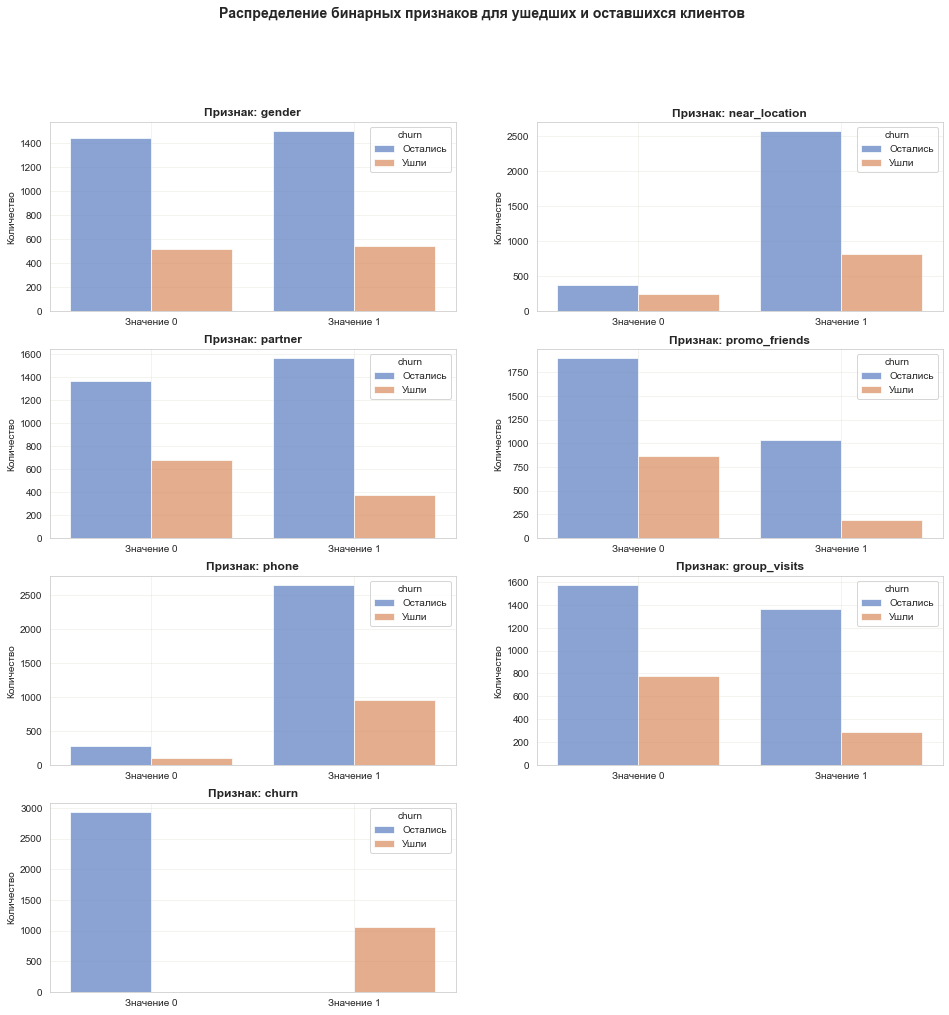

In [19]:
list_bool_event = list(df.loc[:, df.dtypes == bool])

fig, axes = plt.subplots(4,2, figsize=(16,16))
fig.suptitle(f'Распределение бинарных признаков для ушедших и оставшихся клиентов',
             fontweight='bold',fontsize=14)
for ax, column in zip(axes.flatten(), list_bool_event):
    countplot_make(df,column,'churn')
fig.delaxes(axes[3,1])
plt.show()

`gender` - средние значения одинаковы, но количество оставшихся пользователей двух полов больше  
`near_location` - большинство клиентов проживает или работает в районе, где находится фитнес-центр, данный признак не сильно влият на отток  
`partner` - у партнеров меньший отток  
`promo_friends` - в рамках акции «приведи друга» меньший отток  
`phone` - многие клиенты оставили свои контактные номера телефонов, на отток это не оказывает влияния  
`group_visits` - у тех кто посещает групповые занятия меньший отток  
`churn` - оставшиеся/ушедшие пользователи  

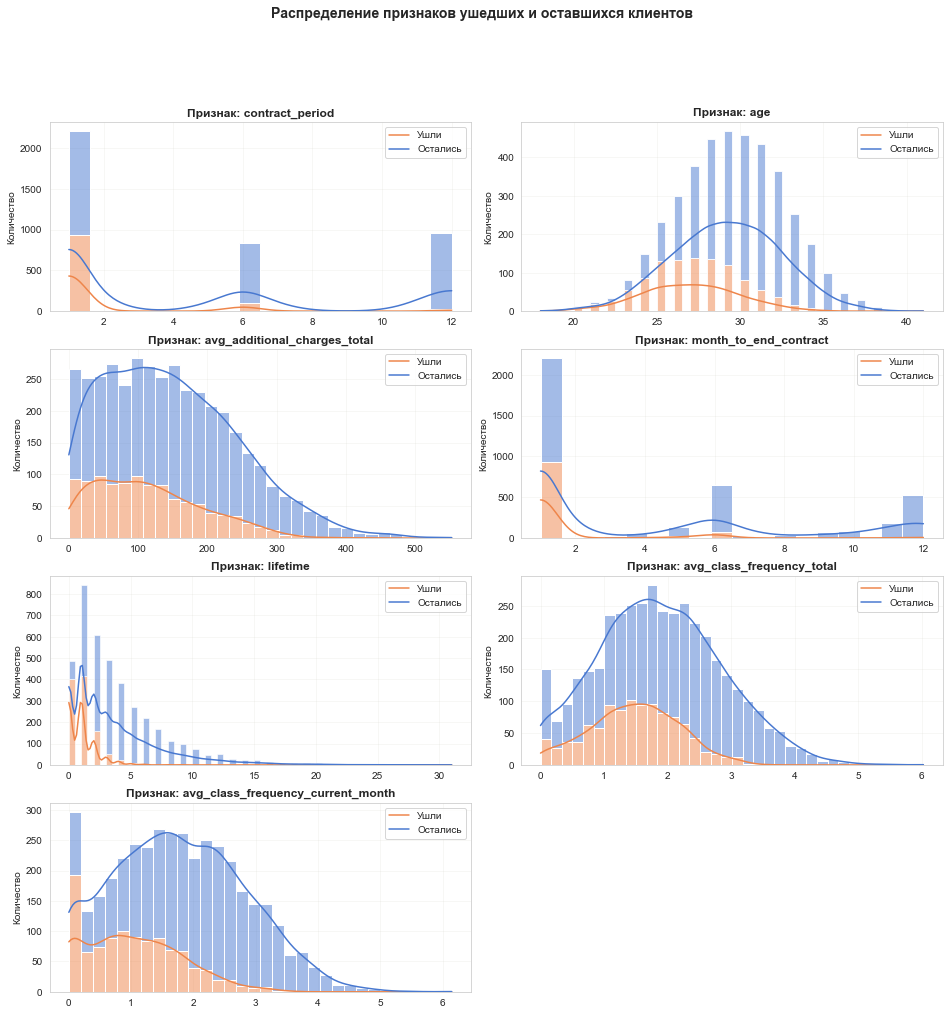

In [21]:
list_event = list(df.loc[:, df.dtypes != bool])

fig, axes = plt.subplots(4,2, figsize=(16,16))
fig.suptitle(f'Распределение признаков ушедших и оставшихся клиентов',
             fontweight='bold',fontsize=14)
for ax, column in zip(axes.flatten(), list_event):
    hist_make(df,column,'churn')
fig.delaxes(axes[3,1])
plt.show()

`contract_period` - чем больше contract_period, тем меньше отток  
`age` - возраст имеет нормальное распределение для оставшихся и ушедших, cредний возраст ушедших 24-28 лет, средний возраст оставшихся 26 - 32 года  
`avg_additional_charges_total` - распределение имеет хвост, большинство значений лежит до 300   
`month_to_end_contract` - основной отток среди тех у кого остался один месяц посещений  
`lifetime` - жизненный цикл для ушедших пользователей в большинстве до 5 месяцев, на начало действия абонимента приходится больше всего значений  
`avg_class_frequency_total` - средняя частота посещений имеет хвост, малое количество клиентов посещяет фитнес-центр больше 4 раз, ушедшие пользователи посещяли 1-3 раза в неделю, оставшиеся 1-4 раза  
`avg_class_frequency_current_month` - наибольший отток с маленькой частотой посещений 0 - 3, значит что клиенты редко посещяли фитнес-центр  

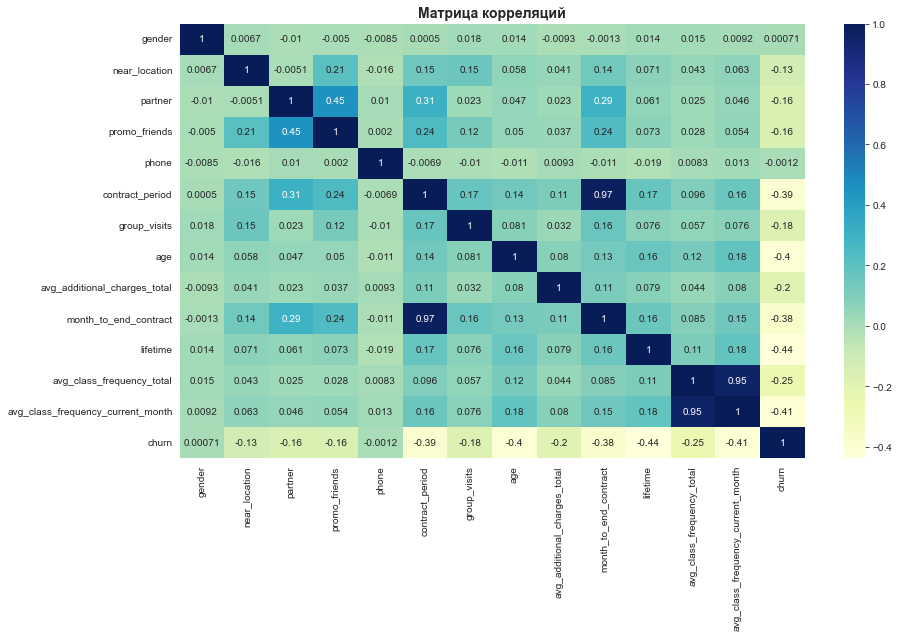

In [22]:
plt.figure(figsize=(14,8))
hm = sns.heatmap(df.corr(),annot = True,square=False,cmap ="YlGnBu")
plt.title('Матрица корреляций',fontweight='bold',fontsize=14)
plt.show()

На матрице корреляций видно, что практически все признаки не имеют влияния на отток, слабую корреляцию имеют несколько признаков: `contract_period`, `age`,`month_to_end_contract`,`lifetime`, `avg_class_frequency_current_month`

#### Вывод:
В ходе анализа данных (EDA) выяснили:
* размер выборки 4000 записей
* дубликатов и пропусков нет
* выборка имеет числовые и категориальные данные в бинарном формате
* практически все признаки не имеют или имеют слабую корреляци к оттоку клиентов

#### Шаг 3. Постройте модель прогнозирования оттока клиентов

##### Разбейте данные на обучающую и валидационную выборку функцией train_test_split()
##### Обучите модель на train-выборке двумя способами: логистической регрессией, случайным лесом.

In [24]:
X = df.drop('churn', axis=1)
y = df['churn'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test) 

##### Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

In [25]:
# список моделей
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state=0)
]

# функция обучает модели и выводит метрики
def metrics(model):
    model.fit(X_train_st, y_train)
    y_prediction = model.predict(X_test_st)
    print(
        'Accuracy: {:.3f} \nPrecision: {:.3f} \nRecall: {:.3f}'.format(
            accuracy_score(y_test, y_prediction),
            precision_score(y_test, y_prediction),
            recall_score(y_test, y_prediction))
    )
    print('')

In [26]:
for i in models:
    print(i)
    metrics(i)

LogisticRegression(random_state=0)
Accuracy: 0.922 
Precision: 0.854 
Recall: 0.828

RandomForestClassifier(random_state=0)
Accuracy: 0.915 
Precision: 0.839 
Recall: 0.813



метрика `Accuracy` логистической регрессии и случайного леса имеет разницу в **0.007**  
метрика `Precision` логистической регрессии и случайного леса имеет разницу в **0.026**  
метрика `Recall` логистической регрессии и случайного леса имеет разницу в **0.015**

Для всех метрик логистическая регрессия дает результат выше и показала себя точнее, чем случайный лес.

### Шаг 4. Сделайте кластеризацию клиентов

##### Стандартизируйте данные.
##### Постройте матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. На основании полученного графика предположите, какое количество кластеров можно выделить.

In [27]:
X_sc = StandardScaler().fit_transform(X)
linked = linkage(X_sc, method = 'ward')

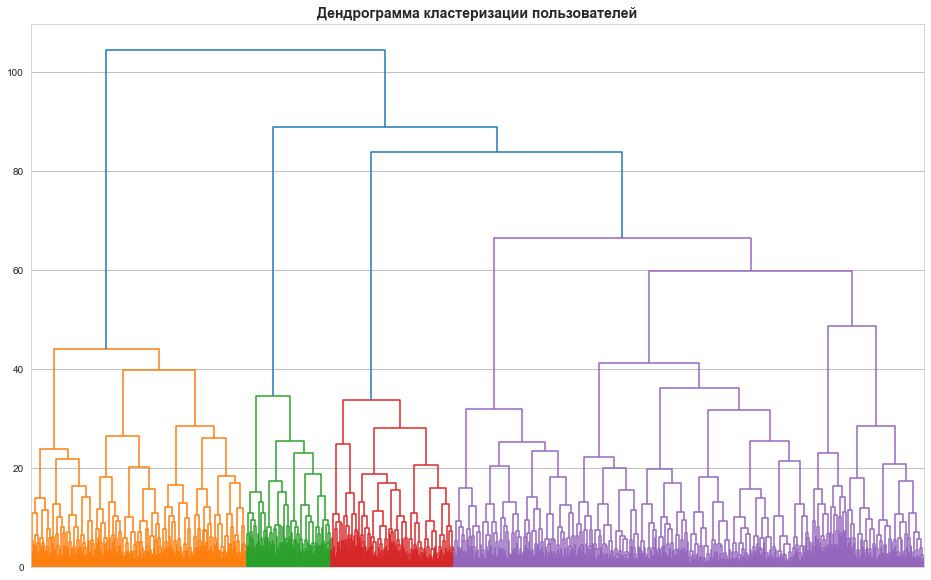

In [28]:
plt.figure(figsize=(16, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма кластеризации пользователей',fontweight='bold',fontsize=14)
plt.grid(True,color='black',alpha=0.3)
plt.xticks([])
plt.show()

На дендрограмме выделяется 4 кластера пользователей 

##### Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов.

За число кластеров примем **n=5** по условию задачи.

In [29]:
# n_clusters - число кластеров
labels = KMeans(n_clusters=5,random_state=0).fit_predict(X_sc)
df['cluster'] = labels

##### Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [30]:
(df
 .groupby('cluster')
 .describe()
 .T
 .reset_index()
 .query('level_1 == "mean" or level_1 == "std"')
 .rename(columns={'level_0':'cluster',
                  'level_1':'value'})
 .set_index(['cluster','value'])
)

cluster                                           0           1           2  \
cluster                           value                                       
contract_period                   mean    10.889109    4.787013    2.352475   
                                  std      2.331663    4.537613    2.701873   
age                               mean    29.982178   29.301299   28.477228   
                                  std      3.095071    3.164356    3.176672   
avg_additional_charges_total      mean   160.761016  143.957664  135.457501   
                                  std     99.942522   94.118283   93.433758   
month_to_end_contract             mean     9.954455    4.475325    2.198020   
                                  std      2.564511    4.254904    2.415311   
lifetime                          mean     4.736634    3.924675    2.809901   
                                  std      3.915857    4.046222    3.146474   
avg_class_frequency_total         mean     1.982055    1.847220    1.660461   
                                  std      0.929259    0.927682    0.842286   
avg_class_frequency_current_month mean     1.974789    1.716369    1.477324   
                                  std      0.934600    1.013286    0.935557   

cluster                                           3           4  
cluster                           value                          
contract_period                   mean     1.948494    2.669451  
                                  std      2.052378    2.658014  
age                               mean    28.167987   30.125298  
                                  std      3.188548    3.109673  
avg_additional_charges_total      mean   131.622204  161.657905  
                                  std     87.055134  103.414330  
month_to_end_contract             mean     1.856577    2.459427  
                                  std      1.872850    2.290733  
lifetime                          mean     2.440571    4.898568  
                                  std      2.861188    4.152755  
avg_class_frequency_total         mean     1.247634    2.852002  
                                  std      0.626695    0.685977  
avg_class_frequency_current_month mean     1.012983    2.850161  
                                  std      0.640400    0.701418

`contract_period` - в 0 кластере средний период контракта 8-12 месяцев, в других кластерах значительно меньше  
`age` - средний возраст различен на +- 1-2 года   
`avg_additional_charges_total` - средняя суммарная выручка выше в кластере 0 и 4  
`month_to_end_contract` - средний период окончания текущего действующего абонемента в 0 кластере выше других  
`lifetime` - наименьший жизненный цикл в кластере 2 и 3  
`avg_class_frequency_total` - средняя частота посещений в неделю за все время выше в кластере 4   
`avg_class_frequency_current_month` - средняя частота посещений в неделю за предыдущий месяц выше в кластере 4 

In [31]:
(df
 .groupby('cluster')
 .describe(include='bool')
 .T
 .reset_index()
 .query('level_1 == "top" or level_1 == "freq"')
 .rename(columns={'level_0':'cluster',
                  'level_1':'value'})
 .set_index(['cluster','value'])
)

cluster                  0      1      2      3      4
cluster       value                                   
gender        top     True   True  False  False   True
              freq     508    201    255    649    469
near_location top     True   True  False   True   True
              freq     969    332    505   1262    818
partner       top     True  False  False  False  False
              freq     791    204    271    820    539
promo_friends top     True  False  False  False  False
              freq     580    267    465    959    645
phone         top     True  False   True   True   True
              freq    1010    385    505   1262    837
group_visits  top     True  False  False  False  False
              freq     548    221    396    831    441
churn         top    False  False  False   True  False
              freq     982    282    281    649    781

##### Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

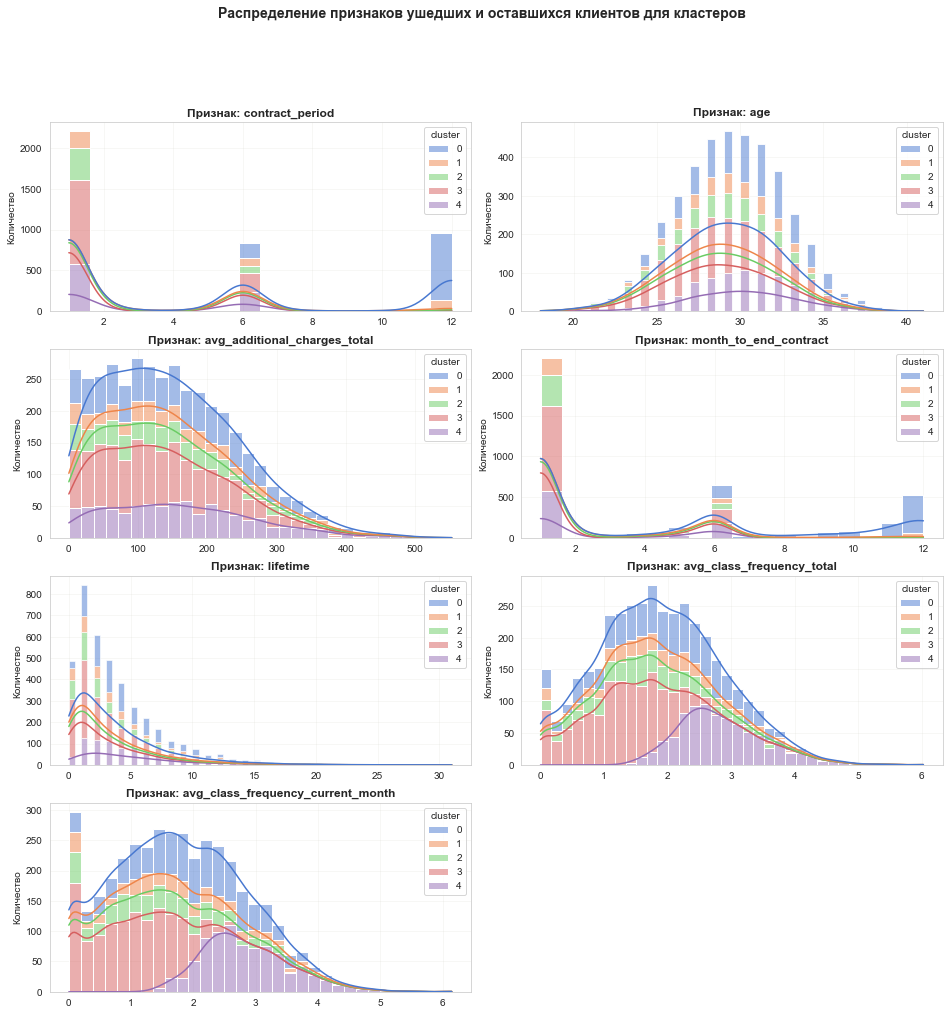

In [32]:
fig, axes = plt.subplots(4,2, figsize=(16,16))
fig.suptitle(f'Распределение признаков ушедших и оставшихся клиентов для кластеров',
             fontweight='bold',fontsize=14)
for ax, column in zip(axes.flatten(), list_event):
    hist_make(df,column,'cluster')
fig.delaxes(axes[3,1])
plt.show()

`contract_period` - в кластере 3 большинство периодов до 2 месяцев, в кластере 0 большинство периодов 12 месяцев  
`age` - кластеры 1,2,3 слегка смещены влево, кластер 4 смещен правее  
`avg_additional_charges_total` - наибольшее количетсов значений в кластере 0, меньше всего в кластере 4, но их среднее значение примерно совпадает  
`month_to_end_contract` - количество абонементов окончивающихся до 2 месяцев выше в кластере 3  
`avg_class_frequency_total` - кластер 4 смещен правее, количество посещений в неделю за весь период больше в этом кластере  
`avg_class_frequency_current_month` - кластер 4 смещен правее, количество посещений в неделю за прошлый месяц больше в этом кластере  

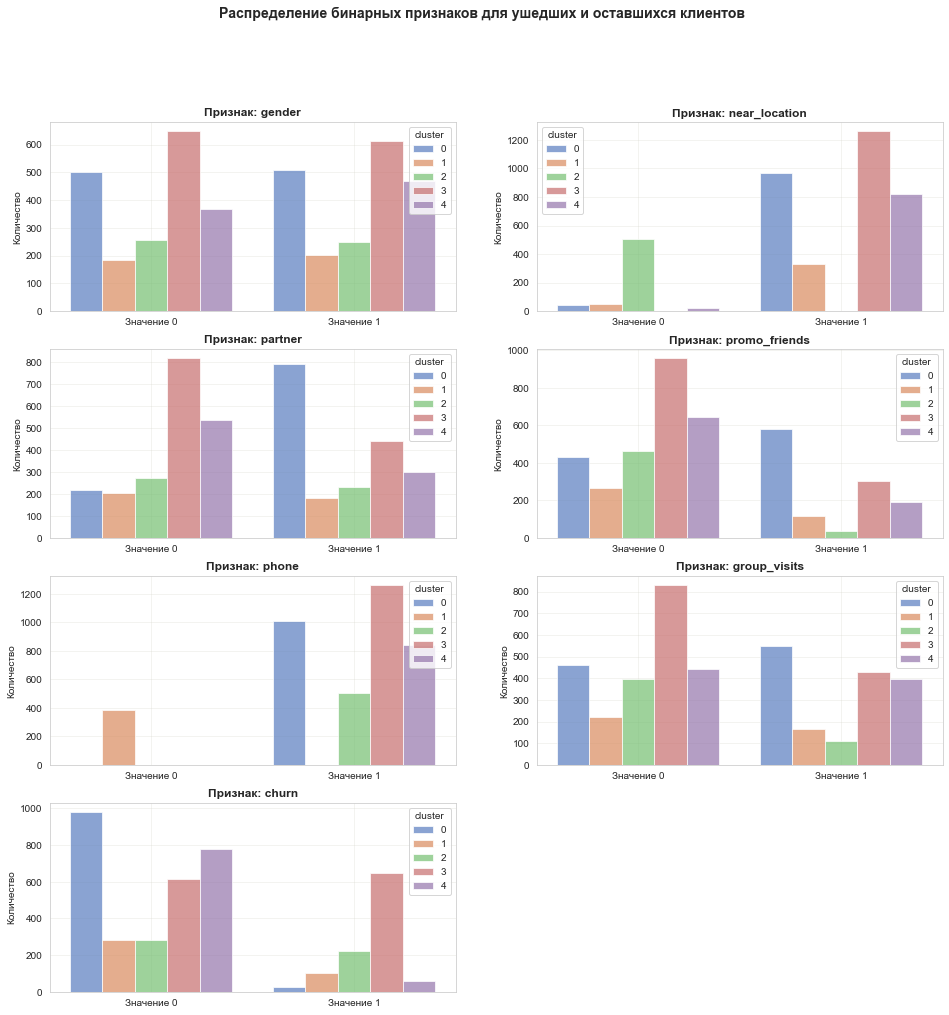

In [33]:
fig, axes = plt.subplots(4,2, figsize=(16,16))
fig.suptitle(f'Распределение бинарных признаков для ушедших и оставшихся клиентов',fontweight='bold',fontsize=14)
for ax, column in zip(axes.flatten(), list_bool_event):
    countplot_make(df,column,'cluster')
fig.delaxes(axes[3,1])
plt.show()

`gender` - оставшихся выше всего в кластере 3, ушедших также в кластере 3  
`near_location` - дальше всего живет кластер 2, ближе всего кластер 3  
`partner` - в 0 значениях выше всего кластер 3, в 1 значениях кластер 0  
`group_visits` - в 0 значениях выше всего кластер 3  
`churn` - больше всего уходят в кластере 3 и 2  

##### Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [34]:
clt_ratio = (df
             .query('churn == 1')
             .groupby('cluster')
             .agg({'churn':'count'})
            ) / df.query('churn == 1').shape[0]
clt_ratio.style.format({'churn':'{:.2%}'})

,churn
cluster,
0,2.64%
1,9.71%
2,21.11%
3,61.17%
4,5.37%


Кластер 3 склонен к оттоку, более надежны кластеры 0 и 4.

### Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

В ходе работы проанализировали выборку и узнали, что:  
* клиенты чей абонемент приобретен на год имеют меньший отток
* средний возраст клиентов 26 - 32 года, чаще уходят более молодые клиенты
* жизненный цикл для ушедших пользователей в большинстве до 5 месяцев
* малое количество клиентов посещяет фитнес-центр больше 4 раз, большинство клиентов занимается 1-4 раза в неделю
* пол клиента не влияет на отток 

Построили модель прогнозирования оттока клиентов двумя методами и выяснили, что для всех метрик логистическая регрессия дает результат выше и показала себя точнее, чем случайный лес.  
Разделили клиентов на 5 кластеров:   

<table border="1" width="100%">
    <thead>
        <tr bgcolor="#f1edf2">
            <th style="text-align:center">Кластеры</th>
            <th style="text-align:center">Описание</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><p><b>Кластер 0</b> 🧑‍🤝‍🧑</p></td>
            <td><p>Любят фитнес и ЗОЖ, чаще используют промо или являются сотрудниками компании-партнёрами клуба, также любители групповых занятий, средний период контракта 8-12 месяцев, доля оттока 2.64%, средняя частота посещений 1-3 раза, средняя суммарная выручка от кластера высокая</p></td>
        </tr>
        <tr>
            <td><p><b>Кластер 1</b> 😶‍🌫️</p></td>
            <td><p>Клиенты-интроверты, вероятно не оставят свой номер телефона, меньше всего используют промо, не очень любят групповые занятия, средний период контракта 0-8 месяцев, доля оттока 9.71%, средняя частота посещений 1-3 раза в неделю, средняя суммарная выручка от кластера хорошая</p></td>
        </tr>
        <tr>
            <td><p><b>Кластер 2</b> 🚙</p></td>
            <td><p>Чаще живут не близко к залу, мало используют промо, средний период контракта 0-4 месяца, доля оттока высокая 21.11%, средняя суммарная выручка от кластера нормальная</p></td>
        </tr>
        <tr>
            <td><p><b>Кластер 3</b> 👀</p></td>
            <td><p>Это те кто пробует фитнес/присматриваются к фитнес-центру, т.к. имеют наибольший отток, ходят в зал мало, живут близко, средняя частота посещений 1-2 раза в неделю, средняя суммарная выручка от кластера низкая, средний период контракта 0-4 месяца, посещали зал в основном до  2 месяцев, не любят групповые занятия и промо, доля оттока высокая 61.17%</p></td>
        </tr>
        <tr>
            <td><p><b>Кластер 4</b> 💪🏻</p></td>
            <td><p>Можно охарактеризовать как любителей фитнеса и ЗОЖ, большинство периодов до 2 месяцев, живут близко, доля оттока 5.37%, средняя частота посещений 2-4 раза в неделю, средняя суммарная выручка от кластера высокая</p></td>
        </tr>
    </tbody>
</table>

Наибольшая доля оттока от всех ушедших клиентов у кластера 3

Рекомендации:
* Сделать акцент на аудиторию живущих и работающих в данном районе
* увеличить продажи абонементов на 12 месяцев
* предлагать имеющиеся и внедрять новые групповые тренировки